In [1]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import statistics
import sys

from statsmodels.formula.api import ols

import scipy.cluster.hierarchy as scipy_hierarchy
from scipy.spatial.distance import pdist, squareform
from scipy.stats import linregress

from matplotlib import colors as mcolors

In [2]:
# GENERAL CONFIGURATION FOR THE ANALYSIS:
# Adjacency type affects how the adjacency matrix is calculated. The signed method, im not sure if it makes sense
adjacency_type = "unsigned"

In [3]:
# SETTINGS FOR PLOTTING FIGURES
PLOTS_WANTED = True
dpi_general = 500

# Settings for printing dataframes
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)

In [4]:
# Colors for the terminal outputs
ENDC = "\033[0m"
BOLD = "\033[1m"
UNDERLINE = "\033[4m"

OKBLUE = "\033[94m"
OKGREEN = "\033[92m"
WARNING = "\033[93m"
FAIL = "\033[91m"

In [5]:
## Move out of the notebook folder to access datasets
working_dir = os.getcwd()
working_dir = working_dir.strip('notebooks')



## Load the dataset
# Transcriptomics Data - We assume a dataset structure were col are the genes, and rows are the samples
transcriptomics_dataset_dir = working_dir + 'data/5xFAD_paper/expressionList.csv'  
transcriptomics_dataset = pd.read_csv(transcriptomics_dataset_dir, index_col=0)

# Sample info and Clinical Traits Data
sample_info_selection_dir = working_dir + 'data/5xFAD_paper/sampleInfo.csv'
sample_info_selection = pd.read_csv(sample_info_selection_dir)

# Figures Saving output dir
figures_dir = working_dir + 'results/WGCNA_figures_own/'

# Check if the directory exists, and if not, create it
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"{BOLD}{OKBLUE}Creating directory to save results and figures...{ENDC}")



## Make a subset to save RAM
subset_dataset_size = 2000
transcriptomics_dataset = transcriptomics_dataset.iloc[:, :subset_dataset_size] 

# RAM usage estimation in GB
RAM_estimate = (subset_dataset_size * subset_dataset_size * 8) / (1024**3)
print(f"The aproximated RAM to analyse this size of dataset is: {RAM_estimate} GB")


In [ ]:
### Step 1: Data Preprocessing (Normalization)
## Preprocessing: removing obvious outlier on genes and samples
print(f"{BOLD}{OKBLUE}Pre-processing...{ENDC}")



## Prepare and clean data
# Remove genes expressed under this cutoff number along samples - use clustering of samples



## Remove genes with no variation across samples (0 vectors) 
# Also print how many genes have been removed in this steo
num_genes_before = transcriptomics_dataset.shape[1]
transcriptomics_dataset = transcriptomics_dataset.loc[:, (transcriptomics_dataset != 0).any(axis=0)] # Actually droping columns with 0 variation

num_genes_removed = num_genes_before - transcriptomics_dataset.shape[1]
print(f"{BOLD}{WARNING}{num_genes_removed} genes were removed due to having 0 variation across samples...{ENDC}")



# NOTES: Maybe no onlyt genes with no variation, but small variation.




transcriptomics_dataset_filtered = transcriptomics_dataset
print(f"{BOLD}{OKBLUE}Done...{ENDC}")

Pre-processing...
13 genes were removed due to having 0 variation across samples...
Done...


Calculating Correlation Matrix...
Done.


Plotting and Saving the Correlation Matrix...


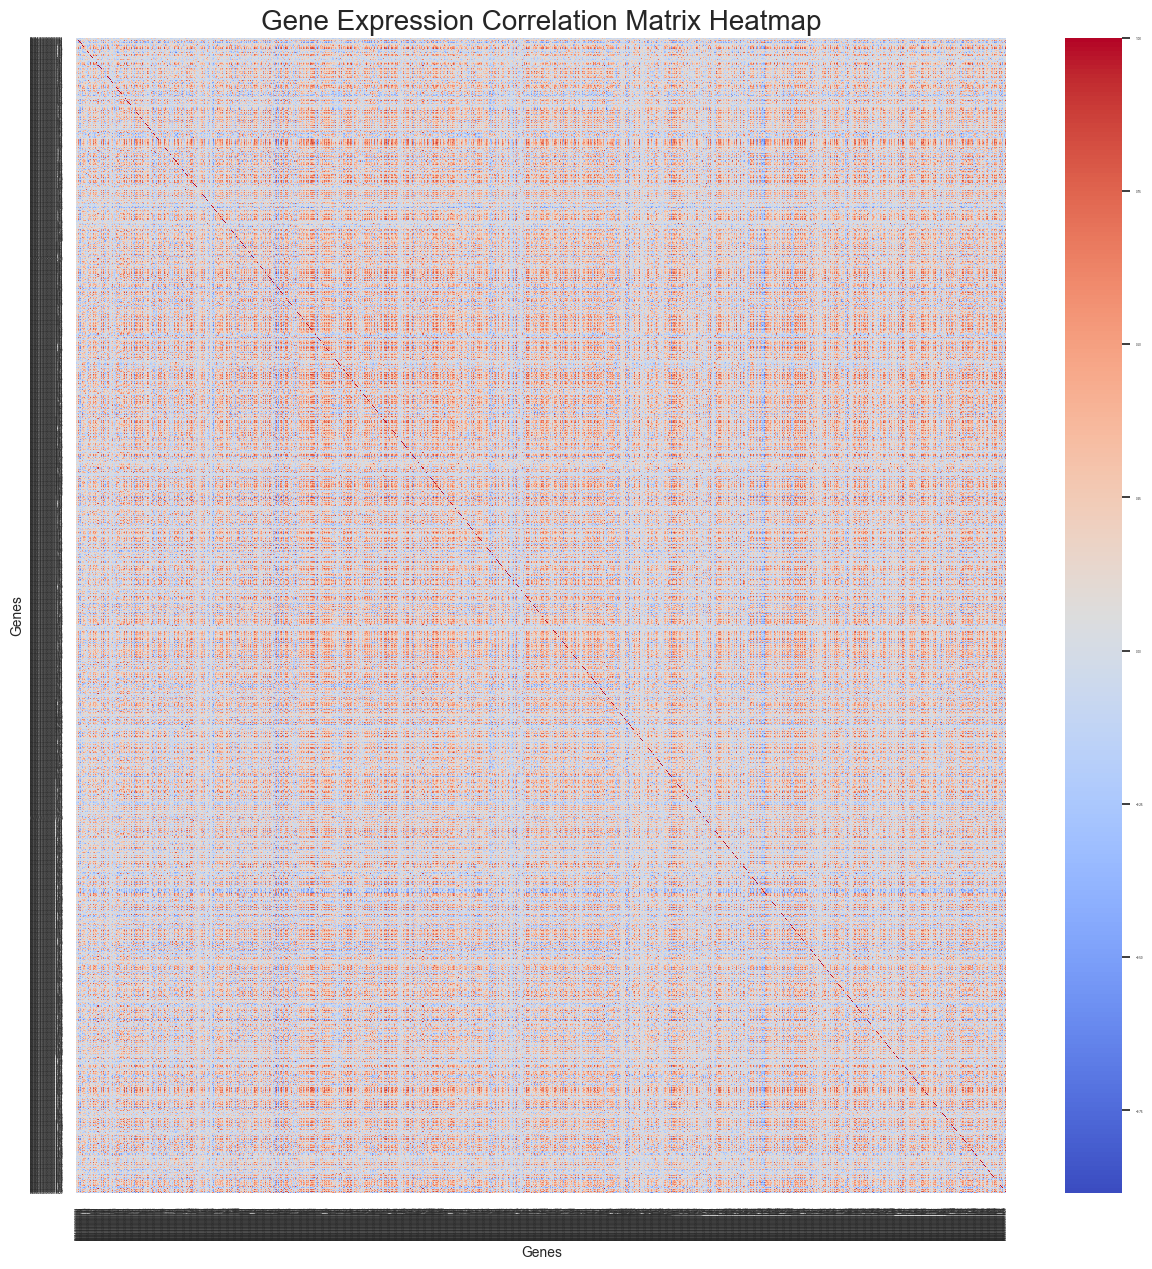

Done


In [ ]:
### Step 2: Constructing a Co-expression Similarity Matrix (Correlation Matrix)
'''
The Correlation matrix, also known as Co-expression Matrix or Similarity matrix is calculated by
calculating the correlation between the expression profiles of all genes. The expression profile of 
a gene is a vector containing the expression levels of that gene for all samples (pacients)
'''


print(f"{BOLD}{OKBLUE}Calculating Correlation Matrix...{ENDC}")

## Calculate the correlation matrix using Pearson correlation
correlation_matrix = transcriptomics_dataset_filtered.corr(method='pearson')

print(f"{BOLD}{OKBLUE}Done.\n\n{ENDC}")



## Plotting the heatmap
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the Correlation Matrix...{ENDC}")
    title_figure = 'Gene Expression Correlation Matrix Heatmap'

    plt.figure(figsize=(15, 15))
    sns.set(font_scale=0.2)
    sns.heatmap(correlation_matrix, cmap='coolwarm', xticklabels=True, yticklabels=True)
    plt.title(title_figure, fontsize=20)
    plt.xlabel('Genes', fontsize=10)
    plt.ylabel('Genes', fontsize=10)
    plt.savefig(figures_dir + title_figure, dpi=dpi_general)
    plt.show()
    sns.set(font_scale=1)

print(f"{BOLD}{OKBLUE}Done{ENDC}")

Transforming Correlation Matrix into Adjacency Matrix...
Starting Soft Power-Thresholding algorithmic search ...
   Power        R²     Slope  Exponential R² Adjusted  mean(connectivity)  median(connectivity)  max(connectivity)
1      1  0.316359  0.351237                 0.612544          412.756523            409.647627         718.375491
2      2  0.600968 -0.508278                 0.798164          153.782883            133.405023         400.688279
3      3  0.809413 -0.811004                 0.942904           74.858248             55.685506         262.254983
4      4  0.878761 -1.026046                 0.956473           42.160363             26.817407         186.349512
5      5  0.906471 -1.168461                 0.954141           25.995666             14.316542         138.693314
6      6  0.893459 -1.258905                 0.932290           17.052417              7.932395         106.680900
7      7  0.915076 -1.287636                 0.955343           11.704586         

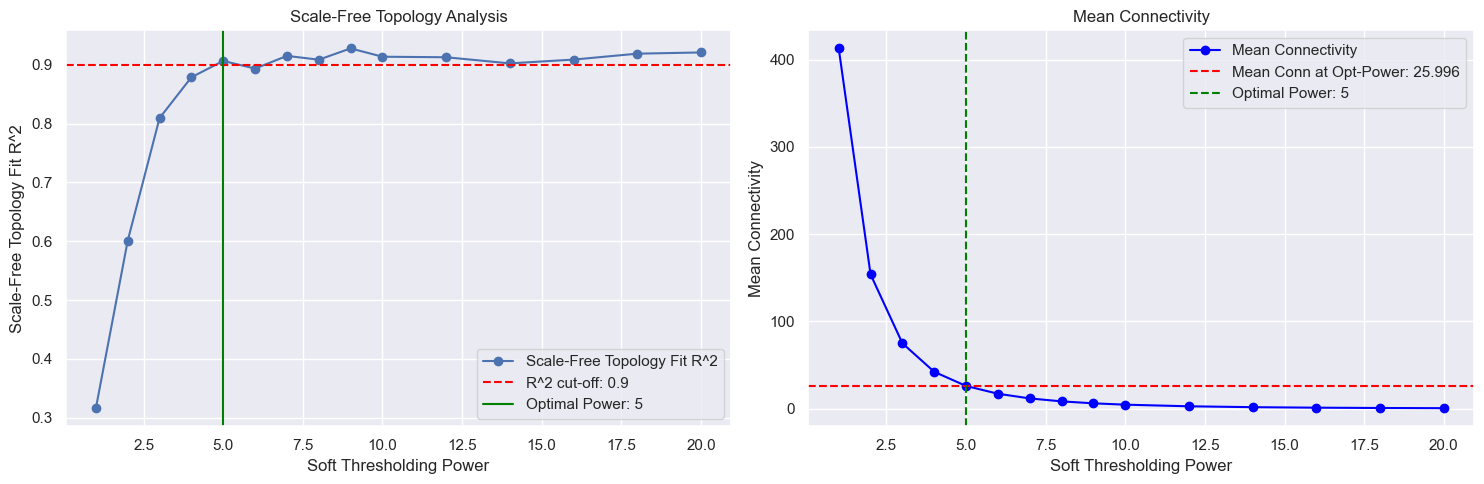

Done


Calculating Adjacency Matrix...
Done


Plotting and Saving the Adjacency Matrix...


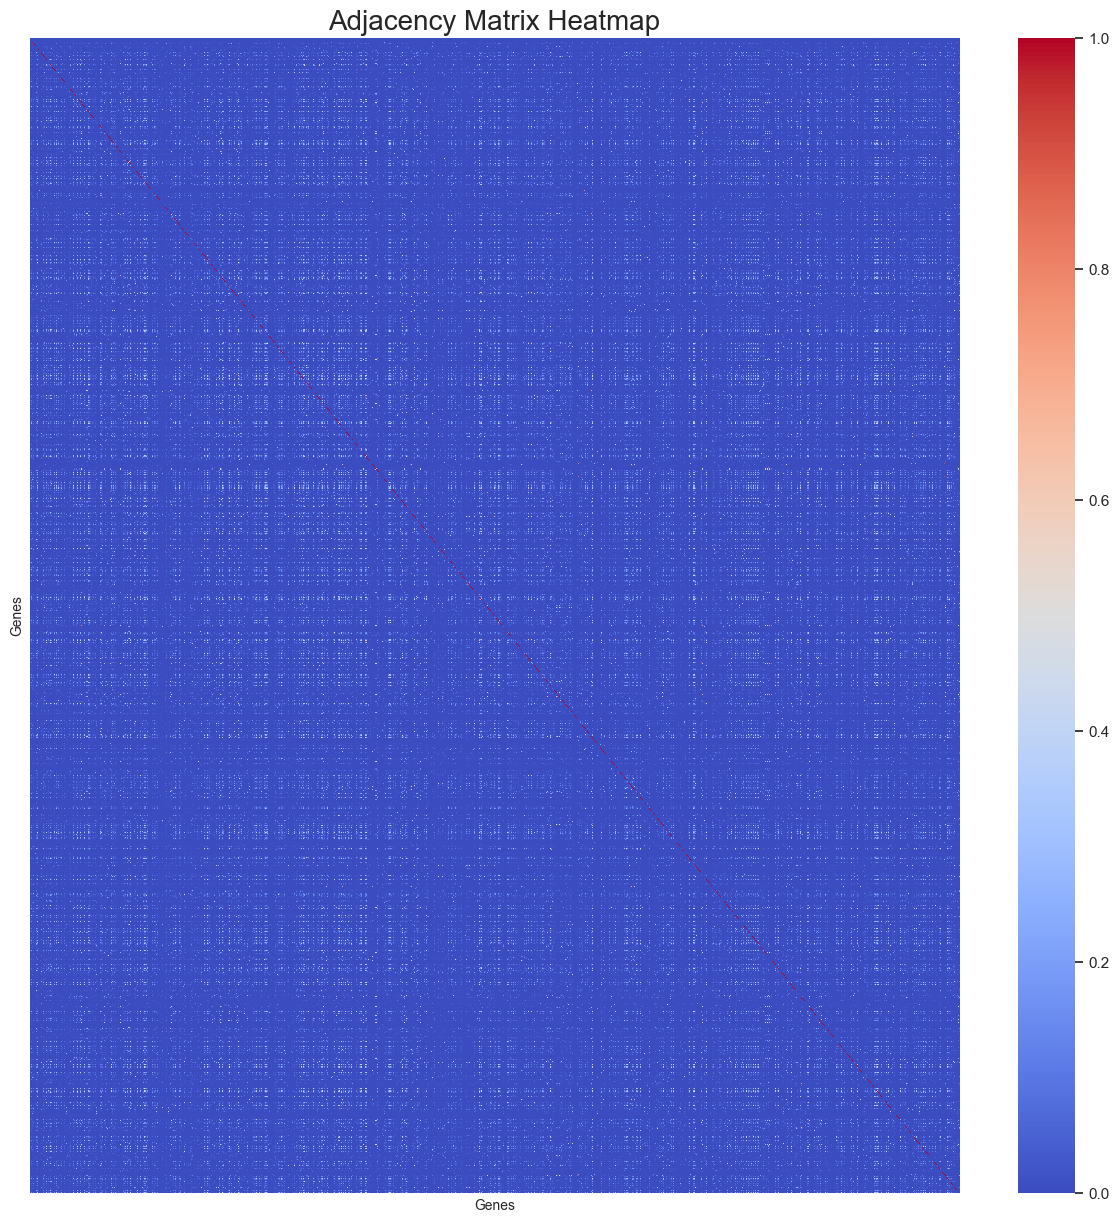

Done


In [ ]:
### Step 3: Transforming into an adjacency matrix using a soft threshold power β
print(f"{BOLD}{OKBLUE}Transforming Correlation Matrix into Adjacency Matrix...{ENDC}")



####################################### FUNCTIONS #######################################

### Function that checks if the adjacency matrix resembles a scale-free network topology (following a power-law distribution).
def scaleFreeFitIndex(connectivity, block_size=10):  # values and code highly taken from pyWGCNA, only small adaptations
    """
    Calculates several fitting statistics to evaluate scale free topology fit.


    block_size = Size of the blocks in which the connectivity is discretized
    """
    

    # Ensure all data is non zero
    connectivity = connectivity[connectivity > 0]

    # Turn the connectivity into a dataframe, and discretize into blocks of block_size size
    connectivity = pd.DataFrame({'data': connectivity})
    connectivity['discretized_connectivity'] = pd.cut(connectivity['data'], block_size)

    # Calculate mean connectivity, probability density for each block
    '''
    mean_connectivity_per_block = connectivity.groupby('discretized_connectivity')['data'].mean().reset_index(name='mean_connectivity_per_block')
    probability_density_per_block = connectivity['discretized_connectivity'].value_counts(normalize=True).reset_index(name='probability_dens_per_block')
    probability_density_per_block['discretized_connectivity'] = probability_density_per_block['index'].apply(lambda x: x.mid)
    '''
    per_block_stats = connectivity.groupby('discretized_connectivity', observed=False)['data'].agg(['mean', 'count']) \
                            .reset_index().rename(columns={'mean': 'mean_connectivity_per_block', 'count': 'count_per_block'})
    per_block_stats['probability_density_per_block'] = per_block_stats['count_per_block'] / len(connectivity)

    # Handle blocks with no values or zero connectivity
    breaks = np.linspace(start=connectivity['data'].min(), stop=connectivity['data'].max(), num=block_size + 1)
    mid_points_blocks = 0.5 * (breaks[:-1] + breaks[1:])  # Mid-points of blocks

    # Impute missing or zero dk values with bin midpoints
    for i, row in per_block_stats.iterrows():
        if pd.isnull(row['mean_connectivity_per_block']) or row['mean_connectivity_per_block'] == 0:
            per_block_stats.at[i, 'mean_connectivity_per_block'] = mid_points_blocks[i]


    # Logarithmic transformation
    per_block_stats['log_mean_conn'] = np.log10(per_block_stats['mean_connectivity_per_block'])
    per_block_stats['log_prob_distr_conn'] = np.log10(per_block_stats['probability_density_per_block'] + 1e-9)

    # Linear regression Model
    simple_linear_regression_model = ols('log_prob_distr_conn ~ log_mean_conn', data=per_block_stats).fit()
    rsquared = simple_linear_regression_model.rsquared
    slope = simple_linear_regression_model.params['log_mean_conn']
    
    # Quadratic Regression Model for Adjusted R-squared
    quadratic_regression_model = ols('log_prob_distr_conn ~ log_mean_conn + I(log_mean_conn**2)', data=per_block_stats).fit()
    rsquared_adj = quadratic_regression_model.rsquared_adj

    return pd.DataFrame({
        'Rsquared.SFT': [rsquared],
        'slope.SFT': [slope],
        'Rsquared Adjusted': [rsquared_adj]
    })



### Function that analyses the network topology of the dataset
def pickSoftThreshold(correlation_matrix, RsquaredCut, MeanCut):
    """
    Analyzes scale-free topology for multiple soft thresholding powers.
    Soft power-thresholding is a value used to power each value of the correlation matrix of the genes to that threshold.
    The assumption is that by raising the correlation values to a power, we will reduce the noise of the correlations in
    the adjacency matrix, therefore putting in relevance important links and tuning down the noise.

    To pick up the threshold, the pickSoftThreshold function calculates for each possible power if the network resembles
    a scale-free network topology (following a power-law distribution).
    The power which produce a higher similarity with a scale-free network is the one returned.

    This is critical in WGCNA, as the premise of the method is that biological networks often exhibit scale-free properties, 
    meaning that a few nodes (genes) are highly connected, while most have few connections.

    
    RsquaredCut: Threshold for the R^2 statistic
    MeanCut: Threshold for the Mean Connectivity statistic
    """


    ## Initial checks and setup of internal variables
    correlation_matrix = correlation_matrix
    powerVector = list(range(1, 11)) + list(range(12, 21, 2))  # values taken from pyWGCNA package
    # Initialize output DataFrame
    results = pd.DataFrame(index=powerVector, columns=["Power"])



    ## Build and adjacency matrix with each power, and test its fit to scale-free network topology
    for power in powerVector:
        # Calculate adjacency matrix from the correlation_matrix with each power
        adjacency_matrix = np.power(np.abs(correlation_matrix), power)
        
        # Calculate connectivity for each node/gene
        connectivity = adjacency_matrix.sum(axis=0) - 1  # we remove the autocorrelation for each row
        
        # Check the resemblance to a scale-free network topology 
        fit_values = scaleFreeFitIndex(connectivity)
        
        # Store results
        results.loc[power, "Power"] = power
        results.loc[power, "R²"] = fit_values['Rsquared.SFT'].values[0]
        results.loc[power, "Slope"] = fit_values['slope.SFT'].values[0]
        results.loc[power, "Exponential R² Adjusted"] = fit_values['Rsquared Adjusted'].values[0]
        results.loc[power, "mean(connectivity)"] = connectivity.mean()
        results.loc[power, "median(connectivity)"] = connectivity.median()
        results.loc[power, "max(connectivity)"] = connectivity.max()
    print(results)


    ## Select the power with the best fit
    valid_powers = results[(results["R²"] > RsquaredCut) & (results["mean(connectivity)"] < MeanCut)]
    if not valid_powers.empty:
        optimal_power = valid_powers.index[0]
    else:
        optimal_power = results["R²"].idxmax()


    print(f"{BOLD}{OKGREEN}The optimal Power-Threshold found is {optimal_power}.{ENDC}")
    return optimal_power, results






## Choosing the soft-thresholding power: analysis of network topology based on the dataset
RsquaredCut = 0.9   # Values from pyWGCNA
MeanCut = 100       # Values from pyWGCNA

print(f"{BOLD}{OKBLUE}Starting Soft Power-Thresholding algorithmic search ...{ENDC}")
optimal_power, results = pickSoftThreshold(correlation_matrix, RsquaredCut, MeanCut) 
print(f"{BOLD}{OKBLUE}Done\n\n{ENDC}")

# Plotting the results
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving Scale-Free Topology fit analysis...{ENDC}")
    title_figure1 = 'Scale-Free Topology Analysis'
    title_figure2 = 'Mean Connectivity'

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plotting Scale-Free Topology Analysis
    axs[0].plot(results.index, results["R²"], marker='o', linestyle='-', label='Scale-Free Topology Fit R^2')
    axs[0].axhline(y=RsquaredCut, color='red', linestyle='--', label=f'R^2 cut-off: {RsquaredCut}')
    axs[0].axvline(x=optimal_power, color='green', linestyle='-', label=f'Optimal Power: {optimal_power}')
    axs[0].set_xlabel('Soft Thresholding Power')
    axs[0].set_ylabel('Scale-Free Topology Fit R^2')
    axs[0].set_title(title_figure1)
    axs[0].legend()

    # Plotting Mean Connectivity vs. Soft Thresholding Power
    mean_connect_optimal_power = results.loc[optimal_power, 'mean(connectivity)']
    axs[1].plot(results.index, results['mean(connectivity)'], marker='o', linestyle='-', color='blue', label='Mean Connectivity')
    axs[1].axhline(y=mean_connect_optimal_power, color='red', linestyle='--', label=f'Mean Conn at Opt-Power: {mean_connect_optimal_power:.3f}')
    axs[1].axvline(x=optimal_power, color='green', linestyle='--', label=f'Optimal Power: {optimal_power}')
    axs[1].set_xlabel('Soft Thresholding Power')
    axs[1].set_ylabel('Mean Connectivity')
    axs[1].set_title(title_figure2)
    axs[1].legend()

    plt.tight_layout()
    plt.savefig(figures_dir + title_figure1 + " and " + title_figure2, dpi=dpi_general)
    plt.show()
    print(f"{BOLD}{OKBLUE}Done\n\n{ENDC}")





## Making the adjacency  matrix out of the correlation matrix, based on the soft-thresholding power selected
print(f"{BOLD}{OKBLUE}Calculating Adjacency Matrix...{ENDC}")

adjacency_type = adjacency_type
if adjacency_type == "unsigned":
    adjacency_matrix = np.power(np.abs(correlation_matrix), optimal_power)
elif adjacency_type == 'signed':
    correlation_matrix = (correlation_matrix + 1) / 2
    adjacency_matrix = np.power(correlation_matrix, optimal_power)

print(f"{BOLD}{OKBLUE}Done\n\n{ENDC}")


## Plotting the heatmap
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the Adjacency Matrix...{ENDC}")
    title_figure = 'Adjacency Matrix Heatmap'

    plt.figure(figsize=(15, 15))
    sns.heatmap(adjacency_matrix, cmap='coolwarm', xticklabels=False, yticklabels=False)
    plt.title(title_figure, fontsize=20)
    plt.xlabel('Genes', fontsize=10)
    plt.ylabel('Genes', fontsize=10)
    plt.savefig(figures_dir + title_figure, dpi=dpi_general)
    plt.show()
    print(f"{BOLD}{OKBLUE}Done{ENDC}")



Transforming Adjacency Matrix into Topological Overlap Matrix (TOM)...
Calculating the TOM...
Done


Plotting and Saving the TOM...


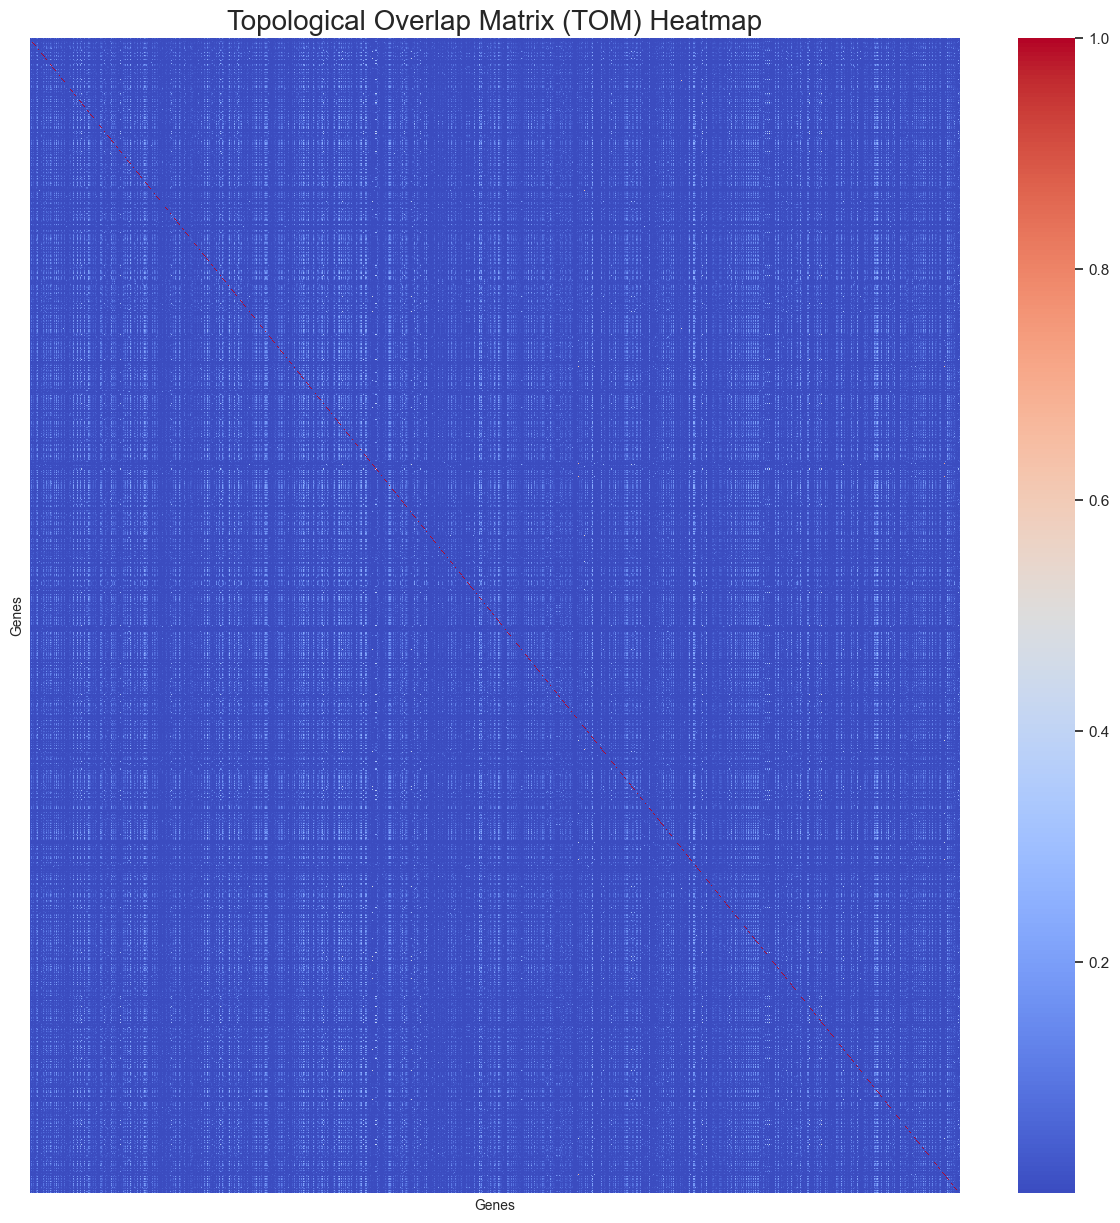

Done


In [ ]:
### Step 4: Converting adjacency matrix into a topological overlap matrix (TOM)
print(f"{BOLD}{OKBLUE}Transforming Adjacency Matrix into Topological Overlap Matrix (TOM)...{ENDC}")



####################################### FUNCTIONS #######################################
def calculate_tom(adjacency_matrix, TOMDenom):
    '''
    This function takes the adjacency matrix and calculates the Topological Overlap Matrix (TOM) from it.
    This matrix is a similarity matrix, using as the similarity metric the amount of genes that two genes 
    have in common, therefore the overlap of neighbors between two genes.

    
    TOMType:  Unsigned or Signed topologies
    TOMDenom: A character string specifying the TOM variant to be used. Recognized values are "min" giving the standard TOM described 
                in Zhang and Horvath (2005), and "mean" in which the min function in the denominator is replaced by mean. The "mean" 
                may produce better results but at this time should be considered experimental.
    '''

    numeric_adjacency_matrix = adjacency_matrix.to_numpy()
    n_rows = numeric_adjacency_matrix.shape[0]

    # Calculate numerator as A^2
    numerator = np.dot(numeric_adjacency_matrix, numeric_adjacency_matrix)

    # Denominator calculation based on TOMDenom selection
    if TOMDenom == "min":
        row_sum = numeric_adjacency_matrix.sum(axis=1).reshape((n_rows, 1))
        col_sum = numeric_adjacency_matrix.sum(axis=0).reshape((1, n_rows))
        denominator = np.minimum(row_sum, col_sum.T) - numeric_adjacency_matrix
    elif TOMDenom == "mean":
        row_sum = numeric_adjacency_matrix.sum(axis=1).reshape((n_rows, 1))
        col_sum = numeric_adjacency_matrix.sum(axis=0).reshape((1, n_rows))
        denominator = (row_sum + col_sum - numeric_adjacency_matrix) / 2

    # Avoid division by zero
    denominator[denominator == 0] = np.nan

    # Calculate the TOM
    TOM = numerator / denominator

    # Set diagonal to 1 as per TOM definition
    np.fill_diagonal(TOM, 1)  

    # Handle NaN values and set them to zero
    TOM = np.nan_to_num(TOM, nan=0)

    # Convert back to DataFrame
    TOM = pd.DataFrame(TOM, index=adjacency_matrix.index, columns=adjacency_matrix.columns)

    return TOM






## Calculating the TOM from the Adjacency Matrix
# TOMDenom must be either 'min' or 'mean'. More explanation in the function itself
TOMDenom = "min"

print(f"{BOLD}{OKBLUE}Calculating the TOM...{ENDC}")
simTOM = calculate_tom(adjacency_matrix, TOMDenom)
dissTOM = 1 - simTOM

print(f"{BOLD}{OKBLUE}Done\n\n{ENDC}")



## Plotting the heatmap
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the TOM...{ENDC}")
    title_figure = 'Topological Overlap Matrix (TOM) Heatmap'

    plt.figure(figsize=(15, 15))
    sns.heatmap(simTOM, cmap='coolwarm', xticklabels=False, yticklabels=False)
    plt.title(title_figure, fontsize=20)
    plt.xlabel('Genes', fontsize=10)
    plt.ylabel('Genes', fontsize=10)
    plt.savefig(figures_dir + title_figure, dpi=dpi_general)
    plt.show()
    print(f"{BOLD}{OKBLUE}Done{ENDC}")


Doing Hierarchical clustering over the dissimilarity TOM (1-TOM)...
Done...


Plotting and Saving the Dendogram from the Hierarchical clustering...


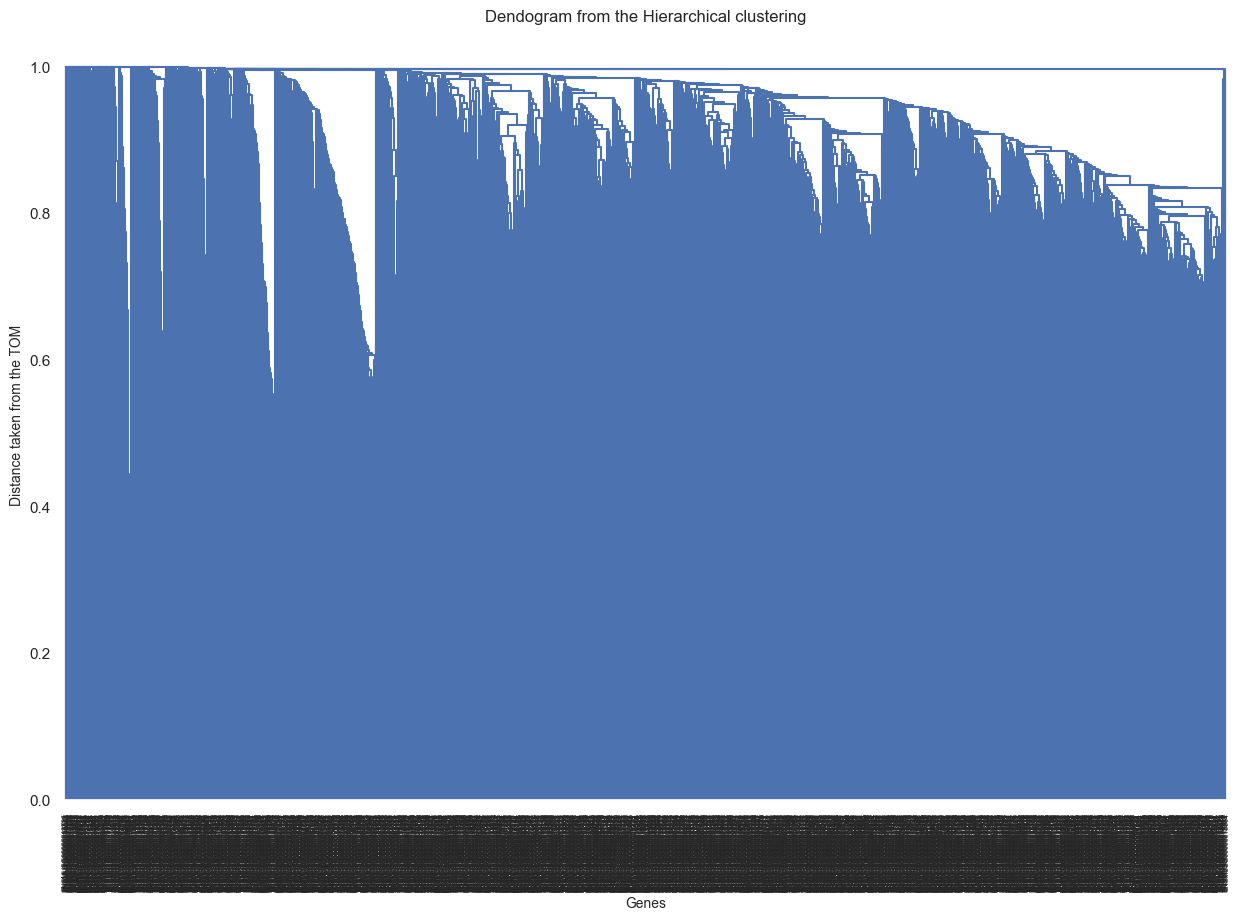

Done


In [ ]:
### Step 5: Hierarchical clustering
## We use a dendogram where the distances are taken from the dissTOM 


print(f"{BOLD}{OKBLUE}Doing Hierarchical clustering over the dissimilarity TOM (1-TOM)...{ENDC}")
# Take only one half of the TOM matrix, since it is square and symmetrix
condensed_dissTOM = squareform(dissTOM.values, checks=False)

## Do the Hierarchical clustering
# The different methods can be: "single", "complete", "average", "weighted", "centroid"]
method = "average"  
linkage_matrix = scipy_hierarchy.linkage(condensed_dissTOM, method=method)
print(f"{BOLD}{OKBLUE}Done...\n\n{ENDC}")


## Plot the dendrogram
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the Dendogram from the Hierarchical clustering...{ENDC}")
    title_figure = 'Dendogram from the Hierarchical clustering'

    plt.figure(figsize=(15, 10))
    scipy_hierarchy.dendrogram(linkage_matrix, truncate_mode=None, labels=dissTOM.index, leaf_rotation=90, color_threshold=0)
    plt.title(title_figure)
    plt.xlabel('Genes', fontsize=10)
    plt.ylabel('Distance taken from the TOM', fontsize=10)
    plt.savefig(figures_dir + title_figure, dpi=dpi_general)
    plt.show()
    print(f"{BOLD}{OKBLUE}Done{ENDC}")

Transforming Adjacency Matrix into Topological Overlap Matrix (TOM)...
Plotting and Saving the Dendogram with the modules found with dynamic tree-cutting...


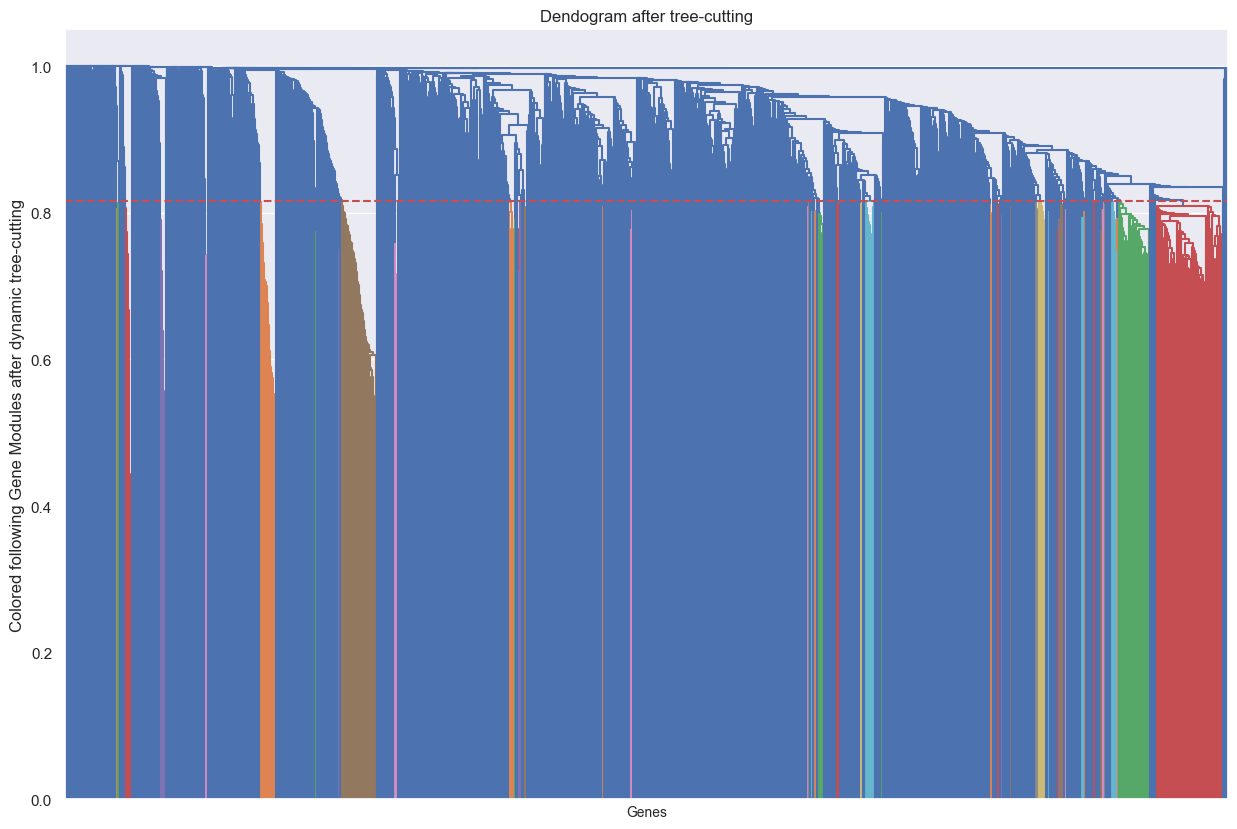

Done


In [ ]:
### Step 6: Module identification
print(f"{BOLD}{OKBLUE}Transforming Adjacency Matrix into Topological Overlap Matrix (TOM)...{ENDC}")



####################################### FUNCTIONS #######################################
def identify_modules(linkage_matrix, dist_matrix, min_memb_cluster, deep_split):
    """
    Enhanced module identification mimicking cutreeHybrid's functionality.
    
    Parameters:
    - linkage_matrix: Linkage matrix from hierarchical clustering.
    - dist_matrix: Squareform distance matrix used in hierarchical clustering.
    - min_memb_cluster: Minimum size of clusters to be considered valid.
    - deep_split: Controls the sensitivity to cluster splitting.
    - cut_height: Threshold for cutting the dendrogram. If None, it will be set dynamically.
    
    Returns:
    - module_assignment: DataFrame mapping each gene to a module.
    - cut_height: The cut height used for cluster formation.
    """
    
    n = linkage_matrix.shape[0] + 1  # Number of observations
    dendro_heights = linkage_matrix[:, 2]
    
    # Dynamic cut height determination
    cut_height = np.percentile(dendro_heights, 100 - deep_split)
    
    # Forming clusters at the determined cut height
    clusters = scipy_hierarchy.fcluster(linkage_matrix, t=cut_height, criterion='distance')
    cluster_sizes = np.bincount(clusters)[1:]  # Size of each cluster, excluding zero index
    
    # Filter clusters based on minimum size and reassign to continuous labels
    valid_clusters = np.where(cluster_sizes >= min_memb_cluster)[0] + 1  # +1 to match cluster labels (not zero-indexed)
    is_valid_cluster = np.isin(clusters, valid_clusters)
    filtered_clusters = clusters[is_valid_cluster]
    
    # Correcting cluster labels to be continuous
    unique_clusters = np.unique(filtered_clusters)
    continuous_labels = np.searchsorted(unique_clusters, filtered_clusters)
    
    # Prepare module assignment DataFrame
    genes = np.arange(1, n + 1)[is_valid_cluster]  # Adjusting genes to filtered list
    module_assignment = pd.DataFrame({'Gene': genes, 'Module': continuous_labels})

    return module_assignment, cut_height




def identify_modules_simple_version(linkage_matrix, min_memb_cluster):
    '''
    Very Basic first approach (written out of what I know about tree cutting) to extract flat clusters (gene modules)
    out of the Dendogram, trying to make it balanced with dynamic parameters.
    '''


    # Dynamically set parameters based on dendrogram size
    min_memb_cluster = min_memb_cluster
    height_percentile = 25  # Use the percentile of heights to set sensitivity
    cut_height_percentile = np.percentile(linkage_matrix[:, 2], height_percentile)
    
    # Set cut_height based on dynamic sensitivity
    max_dendro_height = np.max(linkage_matrix[:, 2])
    sensitivity = max_dendro_height / cut_height_percentile
    cut_height = max_dendro_height / sensitivity

    # Form flat clusters from the dendogram
    cluster_labels = scipy_hierarchy.fcluster(linkage_matrix, t=cut_height, criterion='distance')

    # Map genes to their cluster labels in a dataframe
    module_assignment = pd.DataFrame({'Gene': range(1, len(cluster_labels) + 1), 'Module': cluster_labels})

    # Filter out small modules
    module_sizes = module_assignment['Module'].value_counts()
    valid_modules = module_sizes[module_sizes >= min_memb_cluster].index
    module_assignment = module_assignment[module_assignment['Module'].isin(valid_modules)]

    # Reassign module labels to be consecutive
    module_assignment['Module'] = pd.Categorical(module_assignment['Module']).codes + 1

    return module_assignment, cut_height




min_memb_cluster = 20
deep_split=2 # Provides a rough control over sensitivity to cluster splitting. The higher the value, the more and smaller clusters will be produced. (default = 1)
module_assignment, cut_height = identify_modules_simple_version(linkage_matrix, min_memb_cluster)
# module_assignment, cut_height = identify_modules(linkage_matrix, condensed_dissTOM, min_memb_cluster, deep_split)


## Plot the dendrogram
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the Dendogram with the modules found with dynamic tree-cutting...{ENDC}")
    title_figure = 'Dendogram after tree-cutting'

    plt.figure(figsize=(15, 10)) 
    scipy_hierarchy.dendrogram(linkage_matrix, color_threshold=cut_height, no_labels=True)
    plt.title(title_figure)
    plt.xlabel('Genes', fontsize=10)
    plt.ylabel('Colored following Gene Modules after dynamic tree-cutting')
    plt.axhline(y=cut_height, color='r', linestyle='--')
    plt.savefig(figures_dir + title_figure, dpi=dpi_general)
    plt.show()
    print(f"{BOLD}{OKBLUE}Done{ENDC}")

In [ ]:
module_assignment

In [ ]:
################################################################################################
#                       TERRIBLE CODE FROM pyWGCNA          
################################################################################################
from scipy.cluster.hierarchy import to_tree
from scipy.stats import rankdata
import math
import scipy.stats as stats


def get_heights(Z):

    clusternode = to_tree(Z, True)
    height = np.array([c.dist for c in clusternode[1] if c.is_leaf() is not True])

    return height

def get_merges(z):
    n = z.shape[0]
    merges = np.zeros((z.shape[0], 2), dtype=int)

    for i in range(z.shape[0]):
        for j in range(2):
            if z[i][j] <= n:
                merges[i][j] = -(z[i][j] + 1)
            else:
                cluster = z[i][j] - n
                merges[i][j] = cluster

    return merges

def interpolate(data, index):
    i = round(index)
    n = len(data)
    if i < 1:
        return data[1]
    if i >= n:
        return data[n]
    r = index - i
    return data[i] * (1 - r) + data[i + 1] * r

def coreSizeFunc(BranchSize, minClusterSize):
    BaseCoreSize = minClusterSize / 2 + 1
    if BaseCoreSize < BranchSize:
        CoreSize = int(BaseCoreSize + math.sqrt(BranchSize - BaseCoreSize))
    else:
        CoreSize = BranchSize

    return CoreSize



def cutreeHybrid(dendro, distM, cutHeight=None, minClusterSize=20, deepSplit=1,
                     maxCoreScatter=None, minGap=None, maxAbsCoreScatter=None,
                     minAbsGap=None, minSplitHeight=None, minAbsSplitHeight=None,
                     externalBranchSplitFnc=None, nExternalSplits=0, minExternalSplit=None,
                     externalSplitOptions=pd.DataFrame(), externalSplitFncNeedsDistance=None,
                     assumeSimpleExternalSpecification=True, pamStage=True,
                     pamRespectsDendro=True, useMedoids=False, maxPamDist=None,
                     respectSmallClusters=True):
    """
    Detect clusters in a dendorgram produced by the function hclust.

    :param dendro: a hierarchical clustering dendorgram such as one returned by hclust.
    :type dendro: ndarray
    :param distM: Distance matrix that was used as input to hclust.
    :type distM: pandas dataframe
    :param cutHeight: Maximum joining heights that will be considered. It defaults to 99of the range between the 5th percentile and the maximum of the joining heights on the dendrogram.
    :type cutHeight: int
    :param minClusterSize: Minimum cluster size. (default = 20)
    :type minClusterSize: int
    :param deepSplit: Either logical or integer in the range 0 to 4. Provides a rough control over sensitivity to cluster splitting. The higher the value, the more and smaller clusters will be produced. (default = 1)
    :type deepSplit: int or bool
    :param maxCoreScatter: Maximum scatter of the core for a branch to be a cluster, given as the fraction of cutHeight relative to the 5th percentile of joining heights.
    :type maxCoreScatter: int
    :param minGap: Minimum cluster gap given as the fraction of the difference between cutHeight and the 5th percentile of joining heights.
    :type minGap: int
    :param maxAbsCoreScatter: Maximum scatter of the core for a branch to be a cluster given as absolute heights. If given, overrides maxCoreScatter.
    :type maxAbsCoreScatter: int
    :param minAbsGap: Minimum cluster gap given as absolute height difference. If given, overrides minGap.
    :type minAbsGap: int
    :param minSplitHeight: Minimum split height given as the fraction of the difference between cutHeight and the 5th percentile of joining heights. Branches merging below this height will automatically be merged. Defaults to zero but is used only if minAbsSplitH
    :type minSplitHeight: int
    :param minAbsSplitHeight: Minimum split height given as an absolute height. Branches merging below this height will automatically be merged. If not given (default), will be determined from minSplitHeight above.
    :type minAbsSplitHeight: int
    :param externalBranchSplitFnc: Optional function to evaluate split (dissimilarity) between two branches. Either a single function or a list in which each component is a function.
    :param minExternalSplit: Thresholds to decide whether two branches should be merged. It should be a numeric list of the same length as the number of functions in externalBranchSplitFnc above.
    :type minExternalSplit: list
    :param externalSplitOptions: Further arguments to function externalBranchSplitFnc. If only one external function is specified in externalBranchSplitFnc above, externalSplitOptions can be a named list of arguments or a list with one component.
    :type externalSplitOptions: pandas dataframe
    :param externalSplitFncNeedsDistance: Optional specification of whether the external branch split functions need the distance matrix as one of their arguments. Either NULL or a logical list with one element per branch
    :type externalSplitFncNeedsDistance: pandas dataframe
    :param assumeSimpleExternalSpecification: when minExternalSplit above is a scalar (has length 1), should the function assume a simple specification of externalBranchSplitFnc and externalSplitOptions. (default = True)
    :type assumeSimpleExternalSpecification: bool
    :param pamStage: If TRUE, the second (PAM-like) stage will be performed. (default = True)
    :type pamStage: bool
    :param pamRespectsDendro: If TRUE, the PAM stage will respect the dendrogram in the sense an object can be PAM-assigned only to clusters that lie below it on the branch that the object is merged into. (default = True)
    :type pamRespectsDendro: bool
    :param useMedoids: if TRUE, the second stage will be use object to medoid distance; if FALSE, it will use average object to cluster distance. (default = False)
    :param maxPamDist: Maximum object distance to closest cluster that will result in the object assigned to that cluster. Defaults to cutHeight.
    :type maxPamDist: float
    :param respectSmallClusters: If TRUE, branches that failed to be clusters in stage 1 only because of insufficient size will be assigned together in stage 2. If FALSE, all objects will be assigned individually. (default = False)
    :type respectSmallClusters: bool

    :return: list detailing the deteced branch structure.
    :rtype: list
    """
    dendro_height = get_heights(dendro)
    dendro_merge = get_merges(dendro)

    chunkSize = dendro.shape[0]

    if maxPamDist is None:
        maxPamDist = cutHeight

    nMerge = dendro.shape[0]
    if nMerge < 1:
        sys.exit("The given dendrogram is suspicious: number of merges is zero.")
    if distM is None:
        sys.exit("distM must be non-NULL")
    if distM.shape is None:
        sys.exit("distM must be a matrix.")
    if distM.shape[0] != nMerge + 1 or distM.shape[1] != nMerge + 1:
        sys.exit("distM has incorrect dimensions.")
    if pamRespectsDendro and not respectSmallClusters:
        print("cutreeHybrid Warning: parameters pamRespectsDendro (TRUE) "
                "and respectSmallClusters (FALSE) imply contradictory intent.\n"
                "Although the code will work, please check you really intented "
                "these settings for the two arguments.", flush=True)

    print(f"{OKBLUE}Going through the merge tree...{ENDC}")

    if any(np.diag(distM) != 0):
        np.fill_diagonal(distM, 0)
    refQuantile = 0.05
    refMerge = round(nMerge * refQuantile) - 1
    if refMerge < 0:
        refMerge = 0
    refHeight = dendro[refMerge, 2]
    if cutHeight is None:
        cutHeight = 0.99 * (np.max(dendro_height) - refHeight) + refHeight
        print("..cutHeight not given, setting it to", round(cutHeight, 3),
                " ===>  99% of the (truncated) height range in dendro.", flush=True)
    else:
        if cutHeight > np.max(dendro_height):
            cutHeight = np.max(dendro_height)
    if maxPamDist is None:
        maxPamDist = cutHeight
    nMergeBelowCut = np.count_nonzero(dendro_height <= cutHeight)
    if nMergeBelowCut < minClusterSize:
        print("cutHeight set too low: no merges below the cut.", flush=True)
        return pd.DataFrame({'labels': np.repeat(0, nMerge + 1, axis=0)})

    if externalBranchSplitFnc is not None:
        nExternalSplits = len(externalBranchSplitFnc)
        if len(minExternalSplit) < 1:
            sys.exit("'minExternalBranchSplit' must be given.")
        if assumeSimpleExternalSpecification and nExternalSplits == 1:
            externalSplitOptions = pd.DataFrame(externalSplitOptions)
        # todo: externalBranchSplitFnc = lapply(externalBranchSplitFnc, match.fun)
        for es in range(nExternalSplits):
            externalSplitOptions['tree'][es] = dendro
            if len(externalSplitFncNeedsDistance) == 0 or externalSplitFncNeedsDistance[es]:
                externalSplitOptions['dissimMat'][es] = distM

    MxBranches = nMergeBelowCut
    branch_isBasic = np.repeat(True, MxBranches, axis=0)
    branch_isTopBasic = np.repeat(True, MxBranches, axis=0)
    branch_failSize = np.repeat(False, MxBranches, axis=0)
    branch_rootHeight = np.repeat(np.nan, MxBranches, axis=0)
    branch_size = np.repeat(2, MxBranches, axis=0)
    branch_nMerge = np.repeat(1, MxBranches, axis=0)
    branch_nSingletons = np.repeat(2, MxBranches, axis=0)
    branch_nBasicClusters = np.repeat(0, MxBranches, axis=0)
    branch_mergedInto = np.repeat(0, MxBranches, axis=0)
    branch_attachHeight = np.repeat(np.nan, MxBranches, axis=0)
    branch_singletons = [np.nan] * MxBranches
    branch_basicClusters = [np.nan] * MxBranches
    branch_mergingHeights = [np.nan] * MxBranches
    branch_singletonHeights = [np.nan] * MxBranches
    nBranches = 0

    defMCS = [0.64, 0.73, 0.82, 0.91, 0.95]
    defMG = [(1.0 - defMC) * 3.0 / 4.0 for defMC in defMCS]
    nSplitDefaults = len(defMCS)
    if isinstance(deepSplit, bool):
        deepSplit = pd.to_numeric(deepSplit) * (nSplitDefaults - 2)
    if deepSplit < 0 or deepSplit > nSplitDefaults:
        msg = "Parameter deepSplit (value" + str(deepSplit) + \
                ") out of range: allowable range is 0 through", str(nSplitDefaults - 1)
        sys.exit(msg)
    if maxCoreScatter is None:
        maxCoreScatter = interpolate(defMCS, deepSplit)
    if minGap is None:
        minGap = interpolate(defMG, deepSplit)
    if maxAbsCoreScatter is None:
        maxAbsCoreScatter = refHeight + maxCoreScatter * (cutHeight - refHeight)
    if minAbsGap is None:
        minAbsGap = minGap * (cutHeight - refHeight)
    if minSplitHeight is None:
        minSplitHeight = 0
    if minAbsSplitHeight is None:
        minAbsSplitHeight = refHeight + minSplitHeight * (cutHeight - refHeight)
    nPoints = nMerge + 1
    IndMergeToBranch = np.repeat(0, nMerge, axis=0)
    onBranch = np.repeat(0, nPoints, axis=0)
    RootBranch = 0

    mergeDiagnostics = pd.DataFrame({'smI': np.repeat(np.nan, nMerge, axis=0),
                                        'smSize': np.repeat(np.nan, nMerge, axis=0),
                                        'smCrSc': np.repeat(np.nan, nMerge, axis=0),
                                        'smGap': np.repeat(np.nan, nMerge, axis=0),
                                        'lgI': np.repeat(np.nan, nMerge, axis=0),
                                        'lgSize': np.repeat(np.nan, nMerge, axis=0),
                                        'lgCrSc': np.repeat(np.nan, nMerge, axis=0),
                                        'lgGap': np.repeat(np.nan, nMerge, axis=0),
                                        'merged': np.repeat(np.nan, nMerge, axis=0)})
    if externalBranchSplitFnc is not None:
        externalMergeDiags = pd.DataFrame(np.nan, index=list(range(nMerge)), columns=list(range(nExternalSplits)))

    extender = np.repeat(0, chunkSize, axis=0)

    for merge in range(nMerge):
        if dendro_height[merge] <= cutHeight:
            if dendro_merge[merge, 0] < 0 and dendro_merge[merge, 1] < 0:
                nBranches = nBranches + 1
                branch_isBasic[nBranches - 1] = True
                branch_isTopBasic[nBranches - 1] = True
                branch_singletons[nBranches - 1] = np.append(-1 * dendro_merge[merge, :], extender)
                branch_basicClusters[nBranches - 1] = extender
                branch_mergingHeights[nBranches - 1] = np.append(np.repeat(dendro_height[merge], 2), extender)
                branch_singletonHeights[nBranches - 1] = np.append(np.repeat(dendro_height[merge], 2), extender)
                IndMergeToBranch[merge] = nBranches
                RootBranch = nBranches
            elif np.sign(dendro_merge[merge, 0]) * np.sign(dendro_merge[merge, 1]) < 0:
                clust = IndMergeToBranch[int(np.max(dendro_merge[merge, :])) - 1]

                if clust == 0:
                    sys.exit("Internal error: a previous merge has no associated cluster. Sorry!")

                gene = -1 * int(np.min(dendro_merge[merge, :]))
                ns = branch_nSingletons[clust - 1] + 1
                nm = branch_nMerge[clust - 1] + 1

                if branch_isBasic[clust - 1]:
                    if ns > len(branch_singletons[clust - 1]):
                        branch_singletons[clust - 1] = np.append(branch_singletons[clust - 1], extender)
                        branch_singletonHeights[clust - 1] = np.append(branch_singletonHeights[clust - 1], extender)
                    branch_singletons[clust - 1][ns - 1] = gene
                    branch_singletonHeights[clust - 1][ns - 1] = dendro_height[merge]
                else:
                    onBranch[int(gene) - 1] = clust

                if nm >= len(branch_mergingHeights[clust - 1]):
                    branch_mergingHeights[clust - 1] = np.append(branch_mergingHeights[clust - 1], extender)
                branch_mergingHeights[clust - 1][nm - 1] = dendro_height[merge]
                branch_size[clust - 1] = branch_size[clust - 1] + 1
                branch_nMerge[clust - 1] = nm
                branch_nSingletons[clust - 1] = ns
                IndMergeToBranch[merge] = clust
                RootBranch = clust
            else:
                clusts = IndMergeToBranch[dendro_merge[merge, :].astype(int) - 1]
                sizes = branch_size[clusts - 1]
                rnk = rankdata(sizes, method="ordinal")
                small = clusts[rnk[0] - 1]
                large = clusts[rnk[1] - 1]
                sizes = sizes[rnk - 1]

                if branch_isBasic[small - 1]:
                    coresize = coreSizeFunc(branch_nSingletons[small - 1], minClusterSize)
                    Core = np.array(branch_singletons[small - 1][np.arange(coresize)] - 1, dtype=int)
                    SmAveDist = np.mean(distM.iloc[Core, Core].sum() / coresize - 1)
                else:
                    SmAveDist = 0

                if branch_isBasic[large - 1]:
                    coresize = coreSizeFunc(branch_nSingletons[large - 1], minClusterSize)
                    Core = np.array(branch_singletons[large - 1][np.arange(int(coresize))] - 1, dtype=int)
                    LgAveDist = np.mean(distM.iloc[Core, Core].sum() / coresize - 1)
                else:
                    LgAveDist = 0

                mergeDiagnostics.loc[merge, :] = [small,
                                                    branch_size[small - 1],
                                                    SmAveDist,
                                                    dendro_height[merge] - SmAveDist,
                                                    large,
                                                    branch_size[large - 1],
                                                    LgAveDist,
                                                    dendro_height[merge] - LgAveDist,
                                                    None]
                SmallerScores = [branch_isBasic[small - 1],
                                    branch_size[small - 1] < minClusterSize,
                                    SmAveDist > maxAbsCoreScatter,
                                    dendro_height[merge] - SmAveDist < minAbsGap,
                                    dendro_height[merge] < minAbsSplitHeight]
                if SmallerScores[0] * np.count_nonzero(SmallerScores[1:]) > 0:
                    DoMerge = True
                    SmallerFailSize = ~np.logical_or(SmallerScores[2], SmallerScores[3])
                else:
                    LargerScores = [branch_isBasic[large - 1],
                                    branch_size[large - 1] < minClusterSize,
                                    LgAveDist > maxAbsCoreScatter,
                                    dendro_height[merge] - LgAveDist < minAbsGap,
                                    dendro_height[merge] < minAbsSplitHeight]
                    if LargerScores[0] * np.count_nonzero(LargerScores[1:]) > 0:
                        DoMerge = True
                        SmallerFailSize = ~np.logical_or(LargerScores[2], LargerScores[3])
                        x = small
                        small = large
                        large = x
                        sizes = np.flip(sizes)
                    else:
                        DoMerge = False

                if DoMerge:
                    mergeDiagnostics['merged'][merge] = 1

                if not DoMerge and nExternalSplits > 0 and branch_isBasic[small - 1] and branch_isBasic[large - 1]:
                    branch1 = branch_singletons[large - 1][np.arange(sizes[1])]
                    branch2 = branch_singletons[small - 1][np.arange(sizes[0])]
                    es = 0
                    while es < nExternalSplits and not DoMerge:
                        es = es + 1
                        args = pd.DataFrame({'externalSplitOptions': externalSplitOptions[es - 1],
                                                'branch1': branch1, 'branch2': branch2})
                        # TODO: extSplit = do.call(externalBranchSplitFnc[[es]], args)
                        extSplit = None
                        DoMerge = extSplit < minExternalSplit[es - 1]
                        externalMergeDiags[merge, es - 1] = extSplit
                        mergeDiagnostics['merged'][merge] = 0
                        if DoMerge:
                            mergeDiagnostics['merged'][merge] = 2

                if DoMerge:
                    branch_failSize[small - 1] = SmallerFailSize
                    branch_mergedInto[small - 1] = large
                    branch_attachHeight[small - 1] = dendro_height[merge]
                    branch_isTopBasic[small - 1] = False
                    nss = branch_nSingletons[small - 1]
                    nsl = branch_nSingletons[large - 1]
                    ns = nss + nsl

                    if branch_isBasic[large - 1]:
                        nExt = np.ceil((ns - len(branch_singletons[large - 1])) / chunkSize)
                        if nExt > 0:
                            branch_singletons[large - 1] = np.append(branch_singletons[large - 1],
                                                                        np.repeat(extender, nExt))
                            branch_singletonHeights[large - 1] = np.append(branch_singletonHeights[large - 1],
                                                                            np.repeat(extender, nExt))

                        branch_singletons[large - 1][np.arange(nsl, ns)] = branch_singletons[small - 1][
                            np.arange(nss)]
                        branch_singletonHeights[large - 1][np.arange(nsl, ns)] = branch_singletonHeights[small - 1][
                            np.arange(nss)]
                        branch_nSingletons[large] = ns
                    else:
                        if not branch_isBasic[small - 1]:
                            sys.exit("Internal error: merging two composite clusters. Sorry!")

                        onBranch[branch_singletons[small - 1][branch_singletons[small - 1] != 0] - 1] = large

                    nm = branch_nMerge[large - 1] + 1

                    if nm > len(branch_mergingHeights[large - 1]):
                        branch_mergingHeights[large - 1] = np.append(branch_mergingHeights[large - 1], extender)

                    branch_mergingHeights[large - 1][nm - 1] = dendro_height[merge]
                    branch_nMerge[large - 1] = nm
                    branch_size[large - 1] = branch_size[small - 1] + branch_size[large - 1]
                    IndMergeToBranch[merge] = large
                    RootBranch = large
                else:
                    if branch_isBasic[large - 1] and not branch_isBasic[small - 1]:
                        x = large
                        large = small
                        small = x
                        sizes = np.flip(sizes)

                    if branch_isBasic[large - 1] or (pamStage and pamRespectsDendro):
                        nBranches = nBranches + 1
                        branch_attachHeight[[large - 1, small - 1]] = dendro_height[merge]
                        branch_mergedInto[[large - 1, small - 1]] = nBranches
                        if branch_isBasic[small - 1]:
                            addBasicClusters = small
                        else:
                            addBasicClusters = branch_basicClusters[small - 1]
                        if branch_isBasic[large - 1]:
                            addBasicClusters = np.append(addBasicClusters, large)
                        else:
                            addBasicClusters = np.append(addBasicClusters, branch_basicClusters[large - 1])
                        branch_isBasic[nBranches - 1] = False
                        branch_isTopBasic[nBranches - 1] = False
                        branch_basicClusters[nBranches - 1] = addBasicClusters
                        branch_mergingHeights[nBranches - 1] = np.append(np.repeat(dendro_height[merge], 2),
                                                                            extender)
                        branch_nMerge[nBranches - 1] = 2
                        branch_size[nBranches - 1] = np.sum(sizes)
                        branch_nBasicClusters[nBranches - 1] = len(addBasicClusters)
                        IndMergeToBranch[merge] = nBranches
                        RootBranch = nBranches
                    else:
                        addBasicClusters = [small] if branch_isBasic[small - 1] else branch_basicClusters[small - 1]

                        nbl = branch_nBasicClusters[large - 1]
                        nb = branch_nBasicClusters[large - 1] + len(addBasicClusters)

                        if nb > len(branch_basicClusters[large - 1]):
                            nExt = np.ceil((nb - len(branch_basicClusters[large - 1])) / chunkSize)
                            branch_basicClusters[large - 1] = np.append(branch_basicClusters[large - 1],
                                                                        np.repeat(extender, nExt))

                        branch_basicClusters[large - 1][np.arange(nbl, nb)] = addBasicClusters
                        branch_nBasicClusters[large - 1] = nb
                        branch_size[large - 1] = branch_size[large - 1] + branch_size[small - 1]
                        nm = branch_nMerge[large - 1] + 1

                        if nm > len(branch_mergingHeights[large - 1]):
                            branch_mergingHeights[large - 1] = np.append(branch_mergingHeights[large - 1], extender)

                        branch_mergingHeights[large - 1][nm - 1] = dendro_height[merge]
                        branch_nMerge[large - 1] = nm
                        branch_attachHeight[small - 1] = dendro_height[merge]
                        branch_mergedInto[small - 1] = large
                        IndMergeToBranch[merge] = large
                        RootBranch = large

    isCluster = np.repeat(False, nBranches)
    SmallLabels = np.repeat(0, nPoints)

    for clust in range(nBranches):
        if np.isnan(branch_attachHeight[clust]):
            branch_attachHeight[clust] = cutHeight
        if branch_isTopBasic[clust]:
            coresize = coreSizeFunc(branch_nSingletons[clust], minClusterSize)
            Core = np.array(branch_singletons[clust][np.arange(coresize)] - 1, dtype=int)
            CoreScatter = np.mean(distM.iloc[Core, Core].sum() / (coresize - 1))
            isCluster[clust] = (branch_isTopBasic[clust] and branch_size[clust] >= minClusterSize and
                                CoreScatter < maxAbsCoreScatter and branch_attachHeight[
                                    clust] - CoreScatter > minAbsGap)
        else:
            CoreScatter = 0
        if branch_failSize[clust]:
            SmallLabels[branch_singletons[clust].astype(int) - 1] = clust + 1

    if not respectSmallClusters:
        SmallLabels = np.repeat(0, nPoints)

    Colors = np.zeros((nPoints,))
    coreLabels = np.zeros((nPoints,))
    clusterBranches = np.where(isCluster)[0].tolist()
    branchLabels = np.zeros((nBranches,))
    color = 0

    for clust in clusterBranches:
        color = color + 1
        Colors[branch_singletons[clust][branch_singletons[clust] != 0] - 1] = color
        SmallLabels[branch_singletons[clust][branch_singletons[clust] != 0] - 1] = 0
        coresize = coreSizeFunc(branch_nSingletons[clust], minClusterSize)
        Core = np.array(branch_singletons[clust][np.arange(coresize)] - 1, dtype=int)
        coreLabels[Core] = color
        branchLabels[clust] = color

    Labeled = np.where(Colors != 0)[0].tolist()
    Unlabeled = np.where(Colors == 0)[0].tolist()
    nUnlabeled = len(Unlabeled)
    UnlabeledExist = nUnlabeled > 0

    if len(Labeled) > 0:
        LabelFac = pd.Categorical(Colors[Labeled])
        nProperLabels = len(LabelFac.categories)
    else:
        nProperLabels = 0

    if pamStage and UnlabeledExist and nProperLabels > 0:
        nPAMed = 0
        if useMedoids:
            Medoids = np.repeat(0, nProperLabels)
            ClusterRadii = np.repeat(0, nProperLabels)
            for cluster in range(1, nProperLabels + 1):
                InCluster = np.arange(1, nPoints + 1)[Colors == cluster]
                DistInCluster = distM.iloc[InCluster - 1, InCluster - 1]
                DistSums = DistInCluster.sum(axis=0)
                Medoids[cluster - 1] = InCluster[DistSums.idxmin()]
                ClusterRadii[cluster - 1] = np.max(DistInCluster[:, DistSums.idxmin()])

            if respectSmallClusters:
                FSmallLabels = pd.Categorical(SmallLabels)
                SmallLabLevs = pd.to_numeric(FSmallLabels.categories)
                nSmallClusters = len(FSmallLabels.categories) - (SmallLabLevs[1] == 0)

                if nSmallClusters > 0:
                    for sclust in SmallLabLevs[SmallLabLevs != 0]:
                        InCluster = np.where(SmallLabels == sclust)[0].tolist()
                        if pamRespectsDendro:
                            onBr = np.unique(onBranch[InCluster])
                            if len(onBr) > 1:
                                msg = "Internal error: objects in a small cluster are marked to belong\n " \
                                        "to several large branches:" + str(onBr)
                                sys.exit(msg)

                            if onBr > 0:
                                basicOnBranch = branch_basicClusters[onBr[0] - 1]
                                labelsOnBranch = branchLabels[basicOnBranch - 1]
                            else:
                                labelsOnBranch = None
                        else:
                            labelsOnBranch = list(range(1, nProperLabels + 1))

                        DistInCluster = distM.iloc[InCluster, InCluster]

                        if len(labelsOnBranch) > 0:
                            if len(InCluster) > 1:
                                DistSums = DistInCluster.sum(axis=1)
                                smed = InCluster[DistSums.idxmin()]
                                DistToMeds = distM.iloc[Medoids[labelsOnBranch - 1] - 1, smed]
                                closest = DistToMeds.idxmin()
                                DistToClosest = DistToMeds[closest]
                                closestLabel = labelsOnBranch[closest]
                                if DistToClosest < ClusterRadii[closestLabel - 1] or DistToClosest < maxPamDist:
                                    Colors[InCluster] = closestLabel
                                    nPAMed = nPAMed + len(InCluster)
                            else:
                                Colors[InCluster] = -1
                        else:
                            Colors[InCluster] = -1

            Unlabeled = np.where(Colors == 0)[0].tolist()
            if len(Unlabeled > 0):
                for obj in Unlabeled:
                    if pamRespectsDendro:
                        onBr = onBranch[obj]
                        if onBr > 0:
                            basicOnBranch = branch_basicClusters[onBr - 1]
                            labelsOnBranch = branchLabels[basicOnBranch - 1]
                        else:
                            labelsOnBranch = None
                    else:
                        labelsOnBranch = np.arange(nProperLabels)

                    if labelsOnBranch is not None:
                        UnassdToMedoidDist = distM.iloc[Medoids[labelsOnBranch - 1] - 1, obj]
                        nearest = UnassdToMedoidDist.idxmin()
                        NearestCenterDist = UnassdToMedoidDist[nearest]
                        nearestMed = labelsOnBranch[nearest]
                        if NearestCenterDist < ClusterRadii[nearestMed - 1] or NearestCenterDist < maxPamDist:
                            Colors[obj] = nearestMed
                            nPAMed = nPAMed + 1
                UnlabeledExist = (sum(Colors == 0) > 0)
        else:
            ClusterDiam = np.zeros((nProperLabels,))
            for cluster in range(nProperLabels):
                InCluster = np.where(Colors == cluster)[0].tolist()
                nInCluster = len(InCluster)
                DistInCluster = distM.iloc[InCluster, InCluster]
                if nInCluster > 1:
                    AveDistInClust = DistInCluster.sum(axis=1) / (nInCluster - 1)
                    AveDistInClust.reset_index(drop=True, inplace=True)
                    ClusterDiam[cluster] = AveDistInClust.max()
                else:
                    ClusterDiam[cluster] = 0

            ColorsX = Colors.copy()
            if respectSmallClusters:
                FSmallLabels = pd.Categorical(SmallLabels)
                SmallLabLevs = pd.to_numeric(FSmallLabels.categories)
                nSmallClusters = len(FSmallLabels.categories) - (SmallLabLevs[0] == 0)
                if nSmallClusters > 0:
                    if pamRespectsDendro:
                        for sclust in SmallLabLevs[SmallLabLevs != 0]:
                            InCluster = list(range(nPoints))[SmallLabels == sclust]
                            onBr = pd.unique(onBranch[InCluster])
                            if len(onBr) > 1:
                                msg = "Internal error: objects in a small cluster are marked to belong\n" \
                                        "to several large branches:" + str(onBr)
                                sys.exit(msg)
                            if onBr > 0:
                                basicOnBranch = branch_basicClusters[onBr[0] - 1]
                                labelsOnBranch = branchLabels[basicOnBranch - 1]
                                useObjects = ColorsX in np.unique(labelsOnBranch)
                                DistSClustClust = distM.iloc[InCluster, useObjects]
                                MeanDist = DistSClustClust.mean(axis=0)
                                useColorsFac = ColorsX[useObjects]  # pd.Categorical(ColorsX[useObjects])
                                MeanDist = pd.DataFrame({'MeanDist': MeanDist, 'useColorsFac': useColorsFac})
                                MeanMeanDist = MeanDist.groupby(
                                    'useColorsFac').mean()  # tapply(MeanDist, useColorsFac, mean)
                                nearest = MeanMeanDist[['MeanDist']].idxmin().astype(int) - 1
                                NearestDist = MeanMeanDist[['MeanDist']].min()
                                if np.logical_or(np.all(NearestDist < ClusterDiam[nearest]),
                                                    NearestDist < maxPamDist).tolist()[0]:
                                    Colors[InCluster] = nearest
                                    nPAMed = nPAMed + len(InCluster)
                                else:
                                    Colors[InCluster] = -1
                    else:
                        labelsOnBranch = list(range(nProperLabels))
                        useObjects = np.where(ColorsX != 0)[0].tolist()
                        for sclust in SmallLabLevs[SmallLabLevs != 0]:
                            InCluster = np.where(SmallLabels == sclust)[0].tolist()
                            DistSClustClust = distM.iloc[InCluster, useObjects]
                            MeanDist = DistSClustClust.mean(axis=0)
                            useColorsFac = ColorsX[useObjects]  # pd.Categorical(ColorsX[useObjects])
                            MeanDist = pd.DataFrame({'MeanDist': MeanDist, 'useColorsFac': useColorsFac})
                            MeanMeanDist = MeanDist.groupby(
                                'useColorsFac').mean()  # tapply(MeanDist, useColorsFac, mean)
                            nearest = MeanMeanDist[['MeanDist']].idxmin().astype(int) - 1
                            NearestDist = MeanMeanDist[['MeanDist']].min()
                            if np.logical_or(np.all(NearestDist < ClusterDiam[nearest]),
                                                NearestDist < maxPamDist).tolist()[0]:
                                Colors[InCluster] = nearest
                                nPAMed = nPAMed + len(InCluster)
                            else:
                                Colors[InCluster] = -1

            Unlabeled = np.where(Colors == 0)[0].tolist()
            if len(Unlabeled) > 0:
                if pamRespectsDendro:
                    unlabOnBranch = Unlabeled[onBranch[Unlabeled] > 0]
                    for obj in unlabOnBranch:
                        onBr = onBranch[obj]
                        basicOnBranch = branch_basicClusters[onBr - 1]
                        labelsOnBranch = branchLabels[basicOnBranch]
                        useObjects = ColorsX in np.unique(labelsOnBranch)
                        useColorsFac = ColorsX[useObjects]  # pd.Categorical(ColorsX[useObjects])
                        UnassdToClustDist = distM.iloc[useObjects, obj].groupby(
                            'useColorsFac').mean()  # tapply(distM[useObjects, obj], useColorsFac, mean)
                        nearest = UnassdToClustDist.idxmin().astype(int) - 1
                        NearestClusterDist = UnassdToClustDist[nearest]
                        nearestLabel = pd.to_numeric(useColorsFac.categories[nearest])
                        if np.logical_or(np.all(NearestClusterDist < ClusterDiam[nearest]),
                                            NearestClusterDist < maxPamDist).tolist()[0]:
                            Colors[obj] = nearest
                            nPAMed = nPAMed + 1
                else:
                    useObjects = np.where(ColorsX != 0)[0].tolist()
                    useColorsFac = ColorsX[useObjects]  # pd.Categorical(ColorsX[useObjects])
                    tmp = pd.DataFrame(distM.iloc[useObjects, Unlabeled])
                    tmp['group'] = useColorsFac
                    UnassdToClustDist = tmp.groupby(
                        ['group']).mean()  # apply(distM[useObjects, Unlabeled], 2, tapply, useColorsFac, mean)
                    nearest = np.subtract(UnassdToClustDist.idxmin(axis=0),
                                            np.ones(UnassdToClustDist.shape[1])).astype(
                        int)  # apply(UnassdToClustDist, 2, which.min)
                    nearestDist = UnassdToClustDist.min(axis=0)  # apply(UnassdToClustDist, 2, min)
                    nearestLabel = nearest + 1
                    sumAssign = np.sum(np.logical_or(nearestDist < ClusterDiam[nearest], nearestDist < maxPamDist))
                    assign = np.where(np.logical_or(nearestDist < ClusterDiam[nearest], nearestDist < maxPamDist))[
                        0].tolist()
                    tmp = [Unlabeled[x] for x in assign]
                    Colors[tmp] = [nearestLabel.iloc[x] for x in assign]
                    nPAMed = nPAMed + sumAssign

    Colors[np.where(Colors < 0)[0].tolist()] = 0
    UnlabeledExist = (np.count_nonzero(Colors == 0) > 0)
    NumLabs = list(map(int, Colors.copy()))
    Sizes = pd.DataFrame(NumLabs).value_counts().sort_index()
    OrdNumLabs = pd.DataFrame({"Module": NumLabs, "Rank": np.repeat(1, len(NumLabs))})

    if UnlabeledExist:
        if len(Sizes) > 1:
            SizeRank = np.insert(stats.rankdata(-1 * Sizes[1:len(Sizes)], method='ordinal') + 1, 0, 1)
        else:
            SizeRank = [1]
        for i in range(len(NumLabs)):
            OrdNumLabs.loc[i, 'Rank'] = SizeRank[NumLabs[i] - 1]
    else:
        SizeRank = stats.rankdata(-1 * Sizes, method='ordinal')
        for i in range(len(NumLabs)):
            OrdNumLabs.loc[i, 'Rank'] = SizeRank[NumLabs[i] - 1]

    OrdNumLabs.insert(0, 'Gene', range(1, len(OrdNumLabs['Module']) +1, 1))

    print("\tDone..\n")

    OrdNumLabs.Rank = OrdNumLabs.Rank - UnlabeledExist
    return OrdNumLabs








## Call to the copied function from pyWGCNA
module_assignment = cutreeHybrid(dendro=linkage_matrix, distM=dissTOM, deepSplit=2, pamRespectsDendro=False,
                                         minClusterSize=20)
module_assignment


Going through the merge tree...
..cutHeight not given, setting it to 0.997  ===>  99% of the (truncated) height range in dendro.
	Done..



Gene  Module  Rank
0        1       0    14
1        2       9     9
2        3       0    14
3        4       0    14
4        5       7    10
...    ...     ...   ...
1982  1983       6    13
1983  1984       9     9
1984  1985       3    11
1985  1986      12     7
1986  1987      10     4

[1987 rows x 3 columns]